<a href="https://colab.research.google.com/github/RayAKaan/RH-MHA/blob/main/Variation%202%20%E2%80%94%20seq_len%20%3D%20512.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio matplotlib tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import numpy as np

In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
class CopyTaskDataset(torch.utils.data.Dataset):
    """
    Long-range copy / recall task.

    The model must recall a token that appeared early in the sequence
    when queried much later.
    """

    def __init__(
        self,
        seq_len=384,
        vocab_size=50,
        n_samples=10000,
        query_token=0
    ):
        assert seq_len % 16 == 0, "seq_len must be divisible by window size (16)"
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.n_samples = n_samples
        self.query_token = query_token

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # Tokens in [1, vocab_size-1]
        x = torch.randint(1, self.vocab_size, (self.seq_len,))

        # Information token position (early)
        info_pos = torch.randint(
            low=0,
            high=self.seq_len // 4,
            size=(1,)
        ).item()

        # Query position (late)
        query_pos = torch.randint(
            low=self.seq_len // 2,
            high=self.seq_len,
            size=(1,)
        ).item()

        # Insert query token
        x[query_pos] = self.query_token

        # Target is the token at info_pos
        y = x[info_pos].clone()

        return x, y

In [5]:
class BaselineTransformer(nn.Module):
    """
    Standard Transformer baseline for long-range recall.
    Acts as a fair control against RH-MHA.
    """

    def __init__(
        self,
        vocab_size,
        d_model=128,
        n_layers=4,
        n_heads=4,
        max_seq_len=512
    ):
        super().__init__()

        self.embed = nn.Embedding(vocab_size, d_model)

        # Learnable positional embeddings (important)
        self.pos_embed = nn.Embedding(max_seq_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            batch_first=True,
            norm_first=True  # better stability
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, n_layers)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        """
        x: [B, N]
        """
        B, N = x.shape
        device = x.device

        # Token + position embeddings
        positions = torch.arange(N, device=device).unsqueeze(0).expand(B, N)
        x = self.embed(x) + self.pos_embed(positions)

        # Transformer encoding
        x = self.encoder(x)

        # Global pooling (same as RH model for fairness)
        x = x.mean(dim=1)

        return self.fc(x)

In [6]:
class RH_MHA_v1(nn.Module):
    """
    Recursive Hierarchical Multi-Head Attention (v1)
    - Fixed hierarchy
    - Recursive QKV updates
    - Recursion-level metric logging
    """

    def __init__(
        self,
        d_model,
        heads,
        window=16,
        K=2,
        alpha=0.2,
        beta=0.1
    ):
        super().__init__()

        assert d_model % heads == 0
        self.d = d_model
        self.h = heads
        self.dh = d_model // heads
        self.window = window
        self.K = K
        self.alpha = alpha
        self.beta = beta

        # Shared projections
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)

        self.out = nn.Linear(d_model, d_model, bias=False)

        # Separate norms for stability (important)
        self.ln_q = nn.LayerNorm(d_model)
        self.ln_k = nn.LayerNorm(d_model)
        self.ln_v = nn.LayerNorm(d_model)
        self.ln_x = nn.LayerNorm(d_model)

        # Recursion-level metrics (cleared every forward)
        self.metrics = {}

    def reset_metrics(self):
        self.metrics = {
            "delta": [],
            "entropy": [],
            "qkv_drift": []
        }

    def _attn(self, Q, K, V):
        """
        Multi-head self-attention with entropy tracking
        Q, K, V: [B, T, D]
        """
        B, T, D = Q.shape

        Q = Q.view(B, T, self.h, self.dh).transpose(1, 2)
        K = K.view(B, T, self.h, self.dh).transpose(1, 2)
        V = V.view(B, T, self.h, self.dh).transpose(1, 2)

        scores = (Q @ K.transpose(-2, -1)) / (self.dh ** 0.5)
        A = scores.softmax(dim=-1)

        # Attention entropy (research metric)
        entropy = -(A * (A + 1e-9).log()).sum(dim=-1).mean().item()

        out = (A @ V).transpose(1, 2).contiguous().view(B, T, D)
        return out, entropy

    def forward(self, x):
        """
        x: [B, N, D]
        """
        self.reset_metrics()

        B, N, D = x.shape
        assert N % self.window == 0, "Sequence length must be divisible by window size"

        M = N // self.window
        xw = x.view(B, M, self.window, D)          # local windows
        s = xw.mean(dim=2)                         # summary tokens

        # Initial QKV state
        Qw, Kw, Vw = self.Wq(xw), self.Wk(xw), self.Wv(xw)
        Qs, Ks, Vs = self.Wq(s),  self.Wk(s),  self.Wv(s)

        for k in range(self.K):
            Q_prev = Qw.detach()

            # ---- Local recursive attention ----
            Vw_hat, H = self._attn(
                Qw.view(B * M, self.window, D),
                Kw.view(B * M, self.window, D),
                Vw.view(B * M, self.window, D)
            )
            Vw_hat = Vw_hat.view(B, M, self.window, D)

            Qw = self.ln_q(Qw + self.beta * self.Wq(Vw_hat))
            Kw = self.ln_k(Kw + self.beta * self.Wk(Vw_hat))
            Vw = self.ln_v(Vw + self.beta * self.Wv(Vw_hat))

            # ---- Metrics ----
            delta = (Qw - Q_prev).norm(dim=-1).mean().item()
            drift = (
                Qw.norm(dim=-1).mean()
                + Kw.norm(dim=-1).mean()
                + Vw.norm(dim=-1).mean()
            ).item()

            self.metrics["delta"].append(delta)
            self.metrics["entropy"].append(H)
            self.metrics["qkv_drift"].append(drift)

            # ---- Global recursive attention ----
            s = Vw.mean(dim=2)
            Vs_hat, _ = self._attn(Qs, Ks, Vs)
            Vs = self.ln_v(Vs + self.beta * self.Wv(Vs_hat))

            # ---- Hierarchical feedback ----
            xw = self.ln_x(xw + self.alpha * Vs.unsqueeze(2))

        return self.out(xw.view(B, N, D))

In [7]:
class RHTransformer(nn.Module):
    """
    Transformer wrapper using RH-MHA v1.
    Designed to be a fair comparison with the BaselineTransformer.
    """

    def __init__(
        self,
        vocab,
        d_model=128,
        heads=4,
        window=16,
        K=2,
        max_seq_len=512
    ):
        super().__init__()

        self.embed = nn.Embedding(vocab, d_model)

        # Positional embeddings (important for fairness)
        self.pos_embed = nn.Embedding(max_seq_len, d_model)

        self.rh = RH_MHA_v1(
            d_model=d_model,
            heads=heads,
            window=window,
            K=K
        )

        self.fc = nn.Linear(d_model, vocab)

    def forward(self, x):
        """
        x: [B, N]
        """
        B, N = x.shape
        device = x.device

        # Token + position embeddings
        positions = torch.arange(N, device=device).unsqueeze(0).expand(B, N)
        x = self.embed(x) + self.pos_embed(positions)

        # Recursive hierarchical attention
        x = self.rh(x)

        # Global pooling (same as baseline)
        x = x.mean(dim=1)

        return self.fc(x)

In [8]:
def train(model, loader, epochs=5):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
    loss_fn = nn.CrossEntropyLoss()

    history = {
        "loss": [],
        "accuracy": []
    }

    for ep in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for x, y in tqdm(loader, desc=f"Epoch {ep+1}/{epochs}"):
            x, y = x.to(device), y.to(device)

            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            epoch_loss += loss.item() * x.size(0)

            preds = out.argmax(dim=-1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        avg_loss = epoch_loss / total
        acc = correct / total

        history["loss"].append(avg_loss)
        history["accuracy"].append(acc)

        print(
            f"[Epoch {ep+1}] "
            f"Loss: {avg_loss:.4f} | "
            f"Accuracy: {acc:.4f}"
        )

    return history

In [14]:
# Experiment configuration

TRAIN_SEQ_LEN = 512
MAX_SEQ_LEN   = 768
VOCAB_SIZE    = 50
BATCH_SIZE    = 32
EPOCHS        = 3

# Dataset & DataLoader

train_dataset = CopyTaskDataset(
    seq_len=TRAIN_SEQ_LEN,
    vocab_size=VOCAB_SIZE,
    n_samples=10000
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Models

baseline = BaselineTransformer(
    vocab_size=VOCAB_SIZE,
    d_model=128,
    n_layers=4,
    n_heads=4,
    max_seq_len=MAX_SEQ_LEN
).to(device)

rh_model = RHTransformer(
    vocab=VOCAB_SIZE,
    d_model=128,
    heads=4,
    window=16,
    K=2,
    max_seq_len=MAX_SEQ_LEN
).to(device)

# Sanity check (DO NOT REMOVE)

assert MAX_SEQ_LEN >= TRAIN_SEQ_LEN, "max_seq_len must be >= TRAIN_SEQ_LEN"

# Training

history_base = train(baseline, train_loader, epochs=EPOCHS)
history_rh   = train(rh_model, train_loader, epochs=EPOCHS)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
Epoch 1/3: 100%|██████████| 313/313 [00:47<00:00,  6.65it/s]


[Epoch 1] Loss: 4.0088 | Accuracy: 0.0218


Epoch 2/3: 100%|██████████| 313/313 [00:46<00:00,  6.79it/s]


[Epoch 2] Loss: 3.9373 | Accuracy: 0.0223


Epoch 3/3: 100%|██████████| 313/313 [00:46<00:00,  6.80it/s]


[Epoch 3] Loss: 3.9149 | Accuracy: 0.0232


Epoch 1/3: 100%|██████████| 313/313 [00:04<00:00, 77.20it/s]


[Epoch 1] Loss: 3.9046 | Accuracy: 0.0213


Epoch 2/3: 100%|██████████| 313/313 [00:04<00:00, 76.65it/s]


[Epoch 2] Loss: 3.8982 | Accuracy: 0.0185


Epoch 3/3: 100%|██████████| 313/313 [00:04<00:00, 71.91it/s]

[Epoch 3] Loss: 3.8952 | Accuracy: 0.0181


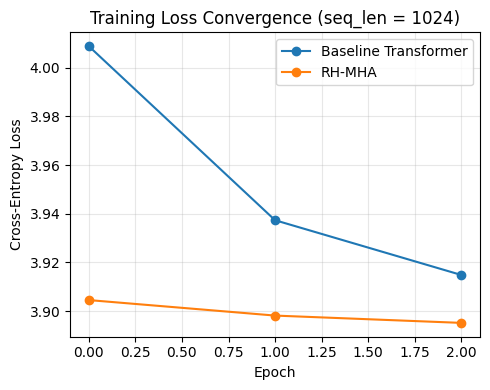

In [15]:
plt.figure(figsize=(5, 4))

plt.plot(
    history_base["loss"],
    marker="o",
    label="Baseline Transformer"
)
plt.plot(
    history_rh["loss"],
    marker="o",
    label="RH-MHA"
)

plt.title("Training Loss Convergence (seq_len = 1024)")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

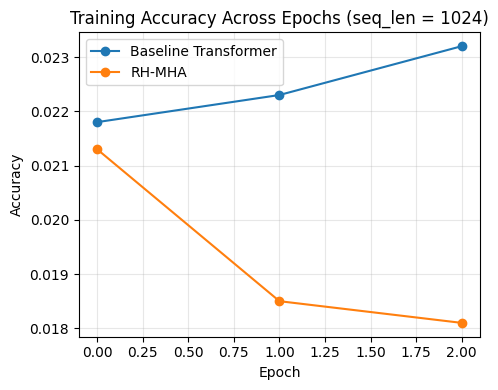

In [16]:
plt.figure(figsize=(5, 4))

plt.plot(
    history_base["accuracy"],
    marker="o",
    label="Baseline Transformer"
)
plt.plot(
    history_rh["accuracy"],
    marker="o",
    label="RH-MHA"
)

plt.title("Training Accuracy Across Epochs (seq_len = 1024)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

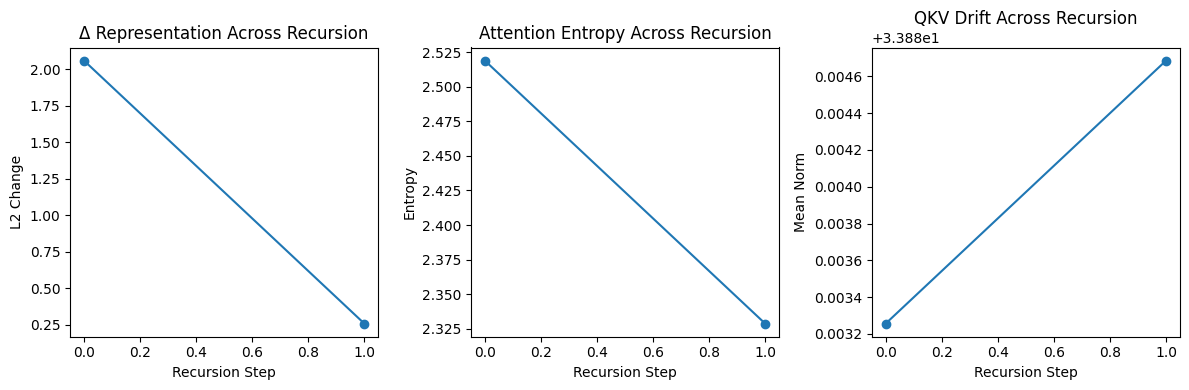

In [17]:
# Recursion-Level Metrics Across Training (RH-MHA)

import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Containers for aggregation
delta_log = defaultdict(list)
entropy_log = defaultdict(list)
drift_log = defaultdict(list)

rh_model.eval()

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)

        # Forward pass
        _ = rh_model(x)

        # Collecting recursion metrics
        metrics = rh_model.rh.metrics
        for k in range(len(metrics["delta"])):
            delta_log[k].append(metrics["delta"][k])
            entropy_log[k].append(metrics["entropy"][k])
            drift_log[k].append(metrics["qkv_drift"][k])

# Aggregating (mean across batches)
avg_delta = [np.mean(delta_log[k]) for k in sorted(delta_log.keys())]
avg_entropy = [np.mean(entropy_log[k]) for k in sorted(entropy_log.keys())]
avg_drift = [np.mean(drift_log[k]) for k in sorted(drift_log.keys())]

# Plots

plt.figure(figsize=(12, 4))

# Δ Representation
plt.subplot(1, 3, 1)
plt.plot(avg_delta, marker="o")
plt.title("Δ Representation Across Recursion")
plt.xlabel("Recursion Step")
plt.ylabel("L2 Change")

# Attention Entropy
plt.subplot(1, 3, 2)
plt.plot(avg_entropy, marker="o")
plt.title("Attention Entropy Across Recursion")
plt.xlabel("Recursion Step")
plt.ylabel("Entropy")

# QKV Drift
plt.subplot(1, 3, 3)
plt.plot(avg_drift, marker="o")
plt.title("QKV Drift Across Recursion")
plt.xlabel("Recursion Step")
plt.ylabel("Mean Norm")

plt.tight_layout()
plt.show()

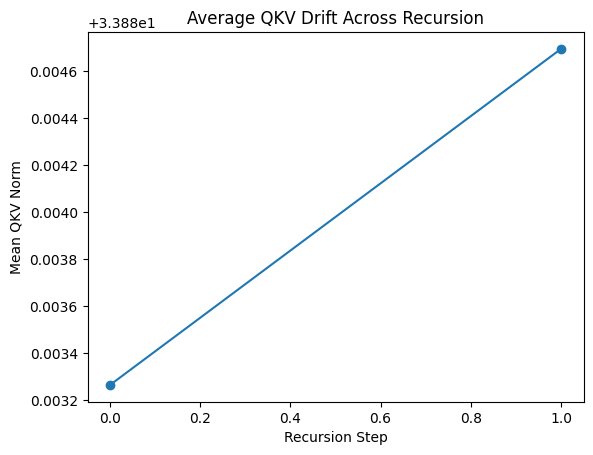

In [18]:
# Aggregating QKV drift across batches

drift_log = defaultdict(list)

rh_model.eval()
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = rh_model(x)

        for k, v in enumerate(rh_model.rh.metrics["qkv_drift"]):
            drift_log[k].append(v)

avg_drift = [np.mean(drift_log[k]) for k in sorted(drift_log.keys())]

plt.plot(avg_drift, marker="o")
plt.xlabel("Recursion Step")
plt.ylabel("Mean QKV Norm")
plt.title("Average QKV Drift Across Recursion")
plt.show()